#Load the GitHub repository from google drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Load libraries

In [0]:
import os
import glob
from pdb import set_trace as bp
from pprint import pprint

In [0]:
import pandas as pd
import numpy as np
try:
  import stumpy
except ModuleNotFoundError as mnfe:
  print(mnfe)
  !pip install stumpy
  import stumpy
try:
  from dask.distributed import Client
except ModuleNotFoundError as mnfe:
  print(mnfe)
  !pip install dask
  from dask.distributed import Client

# Set Paths

In [0]:
DATA_DIR = r'gdrive/My Drive/COVID-19/covid_19/jhu_csse_data/COVID-19/csse_covid_19_data'
TIME_SERIES = os.path.join(DATA_DIR, 'csse_covid_19_time_series')
DAILY_REPORTS = os.path.join(DATA_DIR, 'csse_covid_19_daily_reports')

# ETL 

In [0]:
# TODO: Redo- this whole class. ETL should probably be more functional programming like. The Class part should only read in data sets and not mutate the data in any way. 

class Covid19:
  def __init__(self, path_to_time_series, path_to_daily_reports ):
    self.path_to_time_series = path_to_time_series
    self.path_to_daily_reports = path_to_daily_reports
    self.time_series_data_sources = None
    self.daily_report_data_sources = None
    self.all_dates = None

  def __str__(self):
    return f'''
            Time series data sources: {self.time_series_data_sources}
            Daily Reports: {self.daily_report_data_sources}
            '''

  def read_and_modify_dataframe(self, filepath, filename):
      df = pd.read_csv(filepath)
      df.insert(0, 'FileName', filename)
      return df

  def extract_time_series(self):
    combined_df = pd.DataFrame()
    self.time_series_data_sources = glob.glob(os.path.join(self.path_to_time_series, '*.csv*'))
    for filepath in self.time_series_data_sources:
      filename = os.path.basename(filepath)
      file_type = filename.split('_')[3]  # Get the type of time series file: confirmed, deaths, or recovered
      df = self.read_and_modify_dataframe(filepath, file_type)
      combined_df = combined_df.append(df, ignore_index=True, sort=False)
    return combined_df

  def extract_daily_reports(self):
    combined_df = pd.DataFrame()
    self.daily_report_data_sources = glob.glob(os.path.join(self.path_to_daily_reports, '*.csv*'))
    for filepath in self.daily_report_data_sources:
      filename = os.path.basename(filepath)
      date_of_report = filename.split('.')[0]  # Get the date of the report
      df = self.read_and_modify_dataframe(filepath, date_of_report)
      combined_df = combined_df.append(df, ignore_index=True, sort=False)
    return combined_df

  # TODO:
  #######################
  ## REMOVE FROM CLASS ##
  #######################
  def reassemble_ts_motifs(self, meta_df, matrix_profile, window_size, start_column):
    # Get zeros df
    zeros_df = pd.DataFrame(np.zeros((meta_df.shape[0], window_size)), columns=self.all_dates[-window_size:])

    assert matrix_profile.shape[1] == len(self.all_dates)
    reassembled_df = pd.DataFrame(matrix_profile[:, window_size:], columns=self.all_dates[:-window_size])
    reassembled_df = pd.concat((meta_df, reassembled_df, zeros_df), axis=1)
    return reassembled_df

  # Extracting motifs from time series data as part of a data mining expedition
  # TODO: Use property method to allow for user to aggregate data using different combinations of columns
  def extract_ts_motifs(self, df, **kwargs):
    # Unpack optional runtime parameters
    window_sizes = kwargs.pop('window_sizes', [3])
    client = kwargs.pop('dask_client', '')
    aggregate_fields = kwargs.pop('aggregate_by', '')

    # TODO: Use regex pattern instead
    self.all_dates = [col for col in df.columns if '/20' in col]
    start_column = len(df.columns) - len(self.all_dates)

    combined_df = pd.DataFrame()
    for file_name in df.FileName.unique():
      aggregated_df = df[df.FileName==file_name].groupby(aggregate_fields).sum().reset_index() 
      for window_size in window_sizes:
        # Get the matrix profile
        if client:
          client = Client()
          matrix_profile, matrix_profile_indices = stumpy.mstumped(client, aggregated_df.loc[:, self.all_dates], m=window_size)
        else:
          matrix_profile, matrix_profile_indices = stumpy.mstump(aggregated_df.loc[:, self.all_dates], m=window_size)
          
        # Reassemble the dataframe with the matrix profile and metadata
        reassembled_df = self.reassemble_ts_motifs(aggregated_df.iloc[:, :start_column], matrix_profile, window_size, start_column)
        reassembled_df.insert(0, 'FileName', file_name)
        reassembled_df.insert(1, 'WindowSize', window_size)
        combined_df = combined_df.append(reassembled_df, ignore_index=True, sort=False)
    
    return combined_df

  def reshape_ts_motifs(self, df, raw_df):
    df_list = list()
    
    for index, item in df.iterrows():
      reshaped_df = pd.DataFrame(columns=['Date', 'FileName', 'Country/Region', 'Lat', 'Long', 'confirmed', 'recovered','deaths'])
      reshaped_df['Date'] = self.all_dates
      reshaped_df['Country/Region'] = item['Country/Region']
      reshaped_df['Lat'] = item['Lat']
      reshaped_df['Long'] = item['Long']
      reshaped_df['MinSubseqDistance'] = [item[date] for date in self.all_dates]

      # Get confirmed, recovered, and deaths from original dataframe
      file_type_query = ((raw_df['FileName'] == item['FileName']) & (raw_df['Country/Region']==item['Country/Region']))
      reshaped_df[item['FileName']] = raw_df.loc[file_type_query, self.all_dates].values[0] 
      df_list.append(reshaped_df)

    return pd.concat(df_list, axis=0)


In [18]:
covid_19_data = Covid19(TIME_SERIES, DAILY_REPORTS)
covid_19_ts_df = covid_19_data.extract_time_series()

covid_19_motifs_df = covid_19_data.extract_ts_motifs(covid_19_ts_df, **{'window_sizes': [3, 5, 7, 10],
                                                                 'aggregate_by': ['Country/Region']})

covid_19_motifs_reshaped_df = covid_19_data.reshape_ts_motifs(covid_19_motifs_df, covid_19_ts_df)

print(covid_19_motifs_df)

       FileName  WindowSize  ... 3/23/2020  3/24/2020
0     confirmed           3  ...       0.0        0.0
1     confirmed           3  ...       0.0        0.0
2     confirmed           3  ...       0.0        0.0
3     confirmed           3  ...       0.0        0.0
4     confirmed           3  ...       0.0        0.0
...         ...         ...  ...       ...        ...
2067     deaths          10  ...       0.0        0.0
2068     deaths          10  ...       0.0        0.0
2069     deaths          10  ...       0.0        0.0
2070     deaths          10  ...       0.0        0.0
2071     deaths          10  ...       0.0        0.0

[2072 rows x 134 columns]


In [22]:
covid_19_motifs_reshaped_df = covid_19_data.reshape_ts_motifs(covid_19_motifs_df, covid_19_ts_df)
covid_19_motifs_reshaped_df.head()


,Date,FileName,Country/Region,Lat,Long,Confirmed,Recovered,Deaths,MinSubseqDistance,confirmed,recovered,deaths
0,1/22/20,NaN,Afghanistan,33.0,65.0,NaN,NaN,NaN,"1/22/20 0 1/22/20 0 Name: 0, dtype: object",0.0,NaN,NaN
1,1/23/20,NaN,Afghanistan,33.0,65.0,NaN,NaN,NaN,"1/23/20 0 1/23/20 0 Name: 0, dtype: object",0.0,NaN,NaN
2,1/24/20,NaN,Afghanistan,33.0,65.0,NaN,NaN,NaN,0,0.0,NaN,NaN
3,1/25/20,NaN,Afghanistan,33.0,65.0,NaN,NaN,NaN,0,0.0,NaN,NaN
4,1/26/20,NaN,Afghanistan,33.0,65.0,NaN,NaN,NaN,0,0.0,NaN,NaN


In [0]:
covid_19_motifs_reshaped_df

Are there any anomalous trends in death rates at the country level?

In [0]:
covid_19_country_lvl_df.iloc[:, first_date_column_num:]

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,2/14/2020,2/15/2020,2/16/2020,2/17/2020,2/18/2020,2/19/2020,2/20/2020,2/21/2020,2/22/2020,2/23/2020,2/24/2020,2/25/2020,2/26/2020,2/27/2020,2/28/2020,2/29/2020,3/1/2020,3/2/2020,3/3/2020,3/4/2020,3/5/2020,3/6/2020,3/7/2020,3/8/2020,3/9/2020,3/10/2020,3/11/2020,3/12/2020,3/13/2020,3/14/2020,3/15/2020,3/16/2020,3/17/2020,3/18/2020,3/19/2020,3/20/2020,3/21/2020,3/22/2020,3/23/2020,3/24/2020
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,10.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,8.0,12.0,12.0,12.0,12.0,12.0,32.0,32.0,32.0,65.0,65.0,24.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,15.0,15.0
173,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,6.0,6.0,8.0,8.0,8.0,10.0,10.0,13.0,13.0,14.0,15.0,15.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,14.0,14.0,14.0,14.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,17.0,17.0,17.0,17.0
174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [0]:
covid_19_country_lvl_df

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,...,2/14/2020,2/15/2020,2/16/2020,2/17/2020,2/18/2020,2/19/2020,2/20/2020,2/21/2020,2/22/2020,2/23/2020,2/24/2020,2/25/2020,2/26/2020,2/27/2020,2/28/2020,2/29/2020,3/1/2020,3/2/2020,3/3/2020,3/4/2020,3/5/2020,3/6/2020,3/7/2020,3/8/2020,3/9/2020,3/10/2020,3/11/2020,3/12/2020,3/13/2020,3/14/2020,3/15/2020,3/16/2020,3/17/2020,3/18/2020,3/19/2020,3/20/2020,3/21/2020,3/22/2020,3/23/2020,3/24/2020
0,Afghanistan,99.0000,195.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,Albania,123.4599,60.5049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,10.0
2,Algeria,84.1017,4.9788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,8.0,12.0,12.0,12.0,12.0,12.0,32.0,32.0,32.0,65.0,65.0,24.0
3,Andorra,127.5189,4.5654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,Angola,-33.6081,53.6217,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,Venezuela,19.2714,-199.7691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,15.0,15.0
173,Vietnam,48.0000,324.0000,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,6.0,6.0,8.0,8.0,8.0,10.0,10.0,13.0,13.0,14.0,15.0,15.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,14.0,14.0,14.0,14.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,17.0,17.0,17.0,17.0
174,West Bank and Gaza,63.9044,70.4664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
175,Zambia,-46.2501,84.8499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [0]:
covid_19_country_lvl_df = covid_19_ts_df.groupby('Country/Region').sum().reset_index()
first_date_column_num = 3 
window_size = 4  # Approximately, how many data points might be found in a pattern

matrix_profile, matrix_profile_indices = stumpy.mstump(covid_19_country_lvl_df.iloc[:, first_date_column_num:].astype(float), m=window_size)

In [0]:
covid_19_country_lvl_df.columns[first_date_column_num:-(1+window_size)]


Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       ...
       '3/11/2020', '3/12/2020', '3/13/2020', '3/14/2020', '3/15/2020',
       '3/16/2020', '3/17/2020', '3/18/2020', '3/19/2020', '3/20/2020'],
      dtype='object', length=123)

In [0]:
all_dates = covid_19_country_lvl_df.columns[first_date_column_num:]
covid_19_ts_mp_zeros_df = pd.DataFrame(np.zeros((covid_19_country_lvl_df.shape[0], window_size)), columns=covid_19_country_lvl_df.columns[-window_size:])
covid_19_ts_mp_df = pd.DataFrame(matrix_profile.T, columns=covid_19_country_lvl_df.columns[first_date_column_num:-window_size])
covid_19_ts_mp_df = pd.concat((covid_19_country_lvl_df.iloc[:, :1], covid_19_ts_mp_df, covid_19_ts_mp_zeros_df), axis=1)


In [0]:
covid_19_ts_mp_df.head()

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,...,2/14/2020,2/15/2020,2/16/2020,2/17/2020,2/18/2020,2/19/2020,2/20/2020,2/21/2020,2/22/2020,2/23/2020,2/24/2020,2/25/2020,2/26/2020,2/27/2020,2/28/2020,2/29/2020,3/1/2020,3/2/2020,3/3/2020,3/4/2020,3/5/2020,3/6/2020,3/7/2020,3/8/2020,3/9/2020,3/10/2020,3/11/2020,3/12/2020,3/13/2020,3/14/2020,3/15/2020,3/16/2020,3/17/2020,3/18/2020,3/19/2020,3/20/2020,3/21/2020,3/22/2020,3/23/2020,3/24/2020
0,Afghanistan,3.650024e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.940697e-08,8.940697e-08,0.000000e+00,0.000000e+00,0.000000e+00,8.940697e-08,3.650024e-08,3.650024e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.650024e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0
1,Albania,8.636050e-08,1.290478e-08,1.825012e-08,3.650024e-08,0.000000e+00,0.000000e+00,3.650024e-08,1.825012e-08,3.115490e-08,1.825012e-08,9.736312e-08,0.000000e+00,9.653734e-08,1.095007e-07,3.871435e-08,1.290478e-08,3.650024e-08,4.986026e-08,5.239297e-08,2.344225e-07,1.589014e-07,2.094608e-07,1.445083e-07,9.657056e-08,2.357892e-07,3.535533e-07,4.423446e-07,1.825012e-08,2.580957e-08,4.405969e-08,2.172451e-07,1.290478e-08,2.580957e-08,0.000000e+00,1.290478e-08,0.000000e+00,0.000000e+00,1.290478e-08,0.000000e+00,...,1.290478e-08,1.825012e-08,1.907044e-07,4.998001e-08,1.825012e-08,1.290478e-08,4.176076e-08,1.492795e-07,9.567883e-08,3.650024e-08,3.115490e-08,3.650024e-08,4.080851e-08,2.580957e-08,1.825012e-08,0.000000e+00,1.290478e-08,1.825012e-08,1.825012e-08,0.000000e+00,1.290478e-08,0.000000e+00,1.290478e-08,0.000000e+00,0.000000e+00,1.290478e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.290478e-08,0.0,0.0,0.0
2,Algeria,3.360832e-07,1.686664e-07,2.433349e-08,1.371708e-07,7.587266e-08,5.650372e-08,8.036178e-08,2.433349e-08,3.293668e-08,6.280813e-08,2.224576e-07,2.076994e-08,2.407783e-07,2.602299e-07,8.882411e-08,3.293668e-08,1.314551e-07,2.198797e-07,1.935229e-07,2.920377e-07,1.758269e-07,3.932234e-07,1.538103e-02,2.826392e-07,3.841340e-03,7.367595e-07,8.081084e-07,2.562480e-07,6.380681e-07,8.879398e-08,4.370854e-07,4.930349e-08,6.370592e-08,1.216675e-08,3.441276e-08,1.216675e-08,0.000000e+00,2.433349e-08,8.603189e-09,...,5.413582e-08,3.293668e-08,2.941560e-07,1.777467e-02,3.650024e-08,9.241251e-08,1.233882e-07,3.928975e-07,1.405965e-07,8.204544e-08,9.961947e-08,6.648034e-08,8.995951e-08,7.161773e-08,1.095007e-07,1.720638e-08,5.802475e-08,3.324017e-08,6.370592e-08,4.214685e-08,2.937313e-08,1.216675e-08,2.076994e-08,8.603189e-09,0.000000e+00,2.433349e-08,1.216675e-08,1.720638e-08,0.000000e+00,0.0,1.216675e-08,1.216675e-08,1.216675e-08,8.603189e-09,0.000000e+00,0.0,1.720638e-08,0.0,0.0,0.0
3,Andorra,7.447792e-02,5.731383e-02,3.487380e-07,2.363707e-07,8.262045e-07,1.579304e-07,2.912994e-07,9.158549e-08,4.050758e-08,1.510879e-07,2.680450e-07,1.250782e-07,4.395627e-07,3.342864e-07,1.336794e-07,4.884515e-08,1.662646e-07,2.873353e-07,2.894180e-07,3.638841e-07,2.542957e-07,3.507134e-0

In [0]:
covid_19_reshaped_df_list = list()
for index, item in covid_19_ts_mp_df.iterrows():
  covid_19_ts_mp_reshaped_df = pd.DataFrame(columns=['Date', 'Country/Region', 'Deaths'])
  covid_19_ts_mp_reshaped_df['Date'] = all_dates
  covid_19_ts_mp_reshaped_df['Country/Region'] = item['Country/Region']
  covid_19_ts_mp_reshaped_df['MinSubseqDistance'] = [item[date] for date in all_dates]
  # Get deaths from original dataframe
  covid_19_ts_mp_reshaped_df['Deaths'] = covid_19_country_lvl_df.loc[(covid_19_country_lvl_df['Country/Region']==item['Country/Region']), all_dates].values[0] 
  covid_19_reshaped_df_list.append(covid_19_ts_mp_reshaped_df)

covid_19_realigned_df = pd.concat(covid_19_reshaped_df_list, axis=0)

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

(0.0, 5000.0)

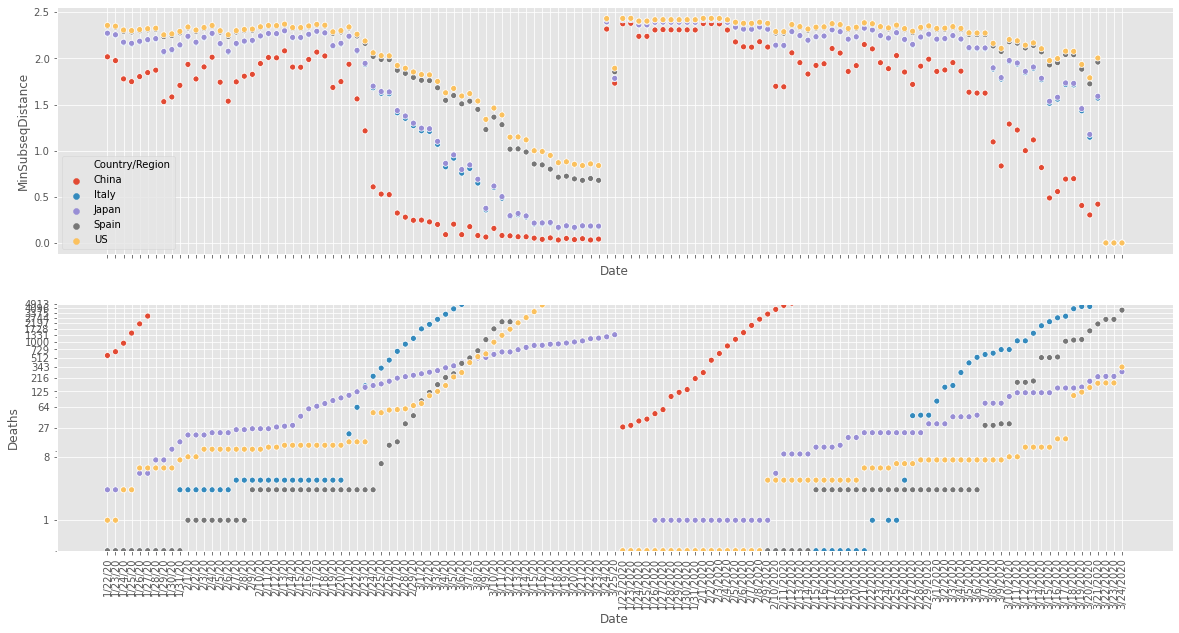

In [0]:
# Plot results for countries of interest
countries_of_interest = ['US', 'Japan', 'China', 'Italy', 'Spain']
query = (covid_19_realigned_df['Country/Region'].isin(countries_of_interest))
covid_19_query_df = covid_19_realigned_df[query] #.groupby(['Date', 'Country/Region']).sum().reset_index()

fig, ax = plt.subplots(2, 1, figsize=(20, 10))

sns.scatterplot(data=covid_19_query_df, x='Date', y='MinSubseqDistance', hue='Country/Region', ax=ax[0], ci=None, legend='brief')
ax[0].set_xticklabels(['']*len(all_dates));

sns.scatterplot(data=covid_19_query_df, x='Date', y='Deaths', hue='Country/Region', ax=ax[1], ci=None, legend=False)
ax[1].set_xticklabels(all_dates, rotation=90);
ax[1].set(yscale='symlog')
ax[1].set_yticks([x ** 3 for x in range(1, 18)])
ax[1].set_yticklabels([str(x ** 3) for x in range(1, 18)])
ax[1].set_ylim(0, 5000)

KeyError: ignored

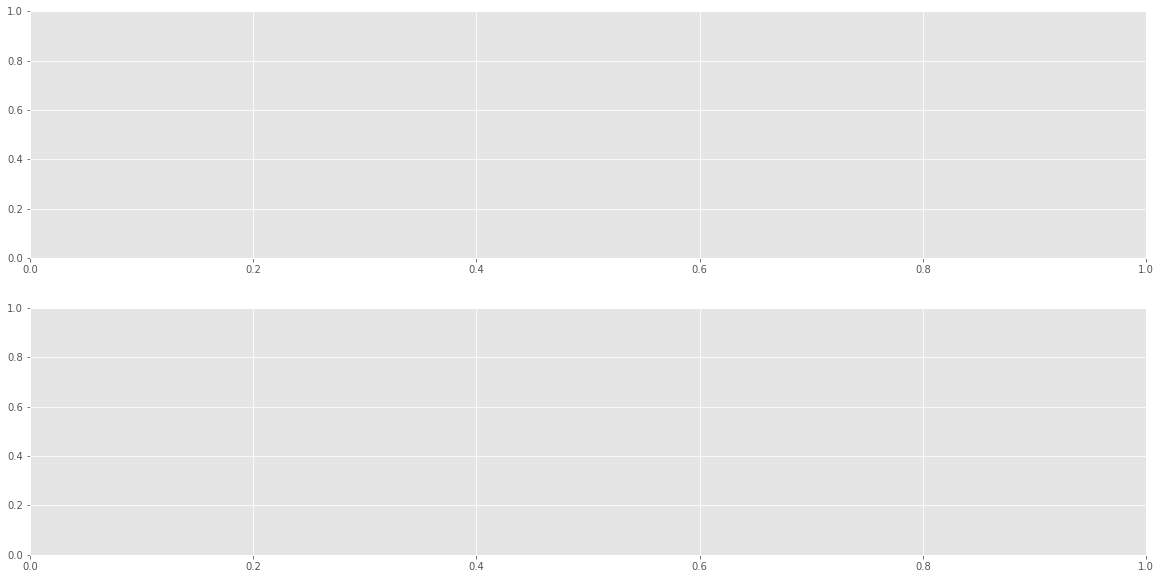

In [0]:
# Plot results for countries of interest
countries_of_interest = ['US', 'Japan', 'China', 'Italy', 'Spain']
query = (covid_19_realigned_df['Country/Region'].isin(countries_of_interest))
covid_19_query_df = covid_19_realigned_df[query] #.groupby(['Date', 'Country/Region']).sum().reset_index()

fig, ax = plt.subplots(2, 1, figsize=(20, 10))

for country in countries_of_interest:
  covid_19_query_df[covid_19_query_df['Country/Region']==country].plot(x='Date', y='MProfile', ax=ax[0])
ax[0].legend(['US', 'Japan', 'China', 'Italy', 'Spain'])
#ax[0].set_xticklabels(['']*len(all_dates));
#ax[0].set_xticklabels(all_dates, rotation=90);

for country in countries_of_interest:
  covid_19_query_df[covid_19_query_df['Country/Region']==country].plot(x='Date', y='Deaths', ax=ax)
ax[1].legend(['US', 'Japan', 'China', 'Italy', 'Spain'])
ax[1].set_xticklabels(all_dates, rotation=90);
ax[1].set(yscale='symlog')
ax[1].set_yticks([x ** 3 for x in range(1, 18)])
ax[1].set_yticklabels([str(x ** 3) for x in range(1, 18)])
ax[1].set_ylim(0, 5000)